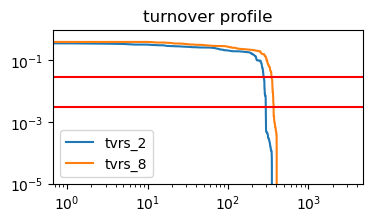

In [1]:
from glob import glob
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
files = glob(f"./pnls/*")

tvrs_2=[]
tvrs_8=[]
for f in files:
    tvr = pd.read_pickle(f)["stat_decay"]["turnover_series"]
    tvrs_2.append(np.quantile(tvr,0.2))
    tvrs_8.append(np.quantile(tvr,0.8))
pd.DataFrame({
    "tvrs_2": sorted(tvrs_2), "tvrs_8": sorted(tvrs_8)
}).iloc[::-1].reset_index(drop=True).plot(logx=True,logy=True,ylim=(1e-5, 1), title="turnover profile", figsize=(4,2))
plt.axhline(y=0.003, color="red")
plt.axhline(y=0.03, color="red")

In [2]:
dfs = [] 
for f in files:
    df = pd.read_pickle(f)
    # Error filter
    if df["stat"]["returns"] == 0:
        continue
    # Minimal robustness filter
    sharpes = pd.Series({y:df[y]["sharpe"] for y in ["stat","stat_delay","stat_decay","stat_nobalance"]})
    if sharpes.max() - sharpes.min() > 0.3:
        continue
    # Low turnover filter (overfit risk)
    if np.quantile(df["stat_decay"]["turnover_series"],0.8) < 0.003:
        continue
    # High turnover filter (tcost)
    if np.quantile(df["stat_decay"]["turnover_series"],0.2) > 0.03: # 0.10:
        continue
    dfs.append(df)

print(f"{len(dfs)}/{len(files)} Selected")

59/3191 Selected


<Axes: title={'center': 'weight profile'}>

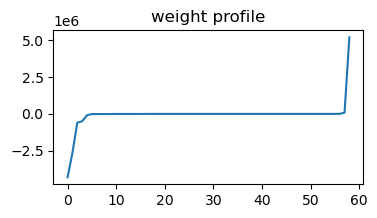

In [3]:
sharpe_threshold = 0.3
# Allows negative weight
weight_function = lambda df: \
    np.maximum(np.abs(df["stat_decay"]["sharpe"])-sharpe_threshold,0) * np.sign(df["stat_decay"]["sharpe"]) \
        / np.power(np.maximum(0.001,np.mean(df["stat_decay"]["turnover_series"])), 3)

# Weight assignment is skewed towards low turnover
pd.Series([weight_function(df) for df in dfs]).sort_values().reset_index(drop=True).plot(title="weight profile", figsize=(4,2))

<Axes: >

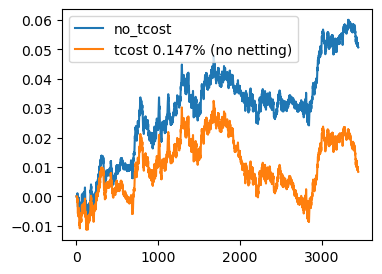

In [4]:
df_ret = pd.DataFrame({
    df["path"]: df["stat_decay"]["returns_series"] * weight_function(df) for df in dfs
}) / np.abs(np.sum([weight_function(df) for df in dfs]))

df_tvr = pd.DataFrame({
    # Ignores netting. (pessimistic assumption)
    #   - accurate estimate requires position data
    # Ignores short cost (optimistic assumption) 
    df["path"]: df["stat_decay"]["turnover_series"] * np.abs(weight_function(df)) for df in dfs
}) / np.abs(np.sum([weight_function(df) for df in dfs]))

gap = 0.001 # daily gap skip
pd.DataFrame({
    "no_tcost": df_ret.sum(axis=1).clip(-gap,gap).cumsum(),
    "tcost 0.147% (no netting)": (df_ret.sum(axis=1) - df_tvr.sum(axis=1) * 0.147 * 0.01).clip(-gap,gap).cumsum(),
}).plot(figsize=(4,3))

Text(0.5, 1.0, 'Covariance')

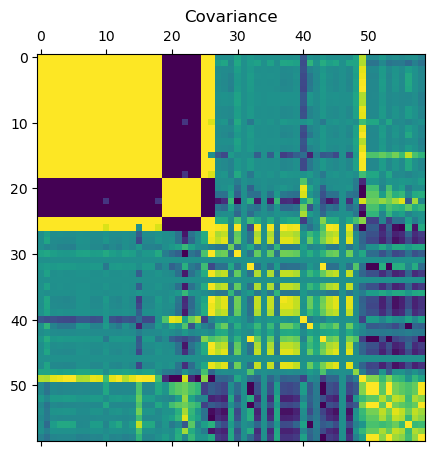

In [5]:
# About 40% of the selected alpha are duplicates
# TODO: Combination better than affine

from scipy.cluster.vq import kmeans, vq
df_r = pd.DataFrame([df["stat_decay"]["returns_series"][-100:] for df in dfs])
codebook, distortion = kmeans(df_r.values, k_or_guess=5)
cluster_idx, _ = vq(df_r.values, codebook)
f = plt.figure(figsize=(5, 5))
plt.matshow(df_r.iloc[np.argsort(cluster_idx)].T.cov().clip(-0.1e-7, 0.1e-7), fignum=f.number)
plt.title("Covariance")